# Project description
General info

This project contains the analysis of **Podcast reviews**: *2 million podcast reviews for 100k podcasts, updated monthly. This dataset is intended to aid in analysis of text feedback and review data.*

Dataset can be downloaded from the following source under CC BY-NC-SA 4.0 license: kaggle.com/datasets/thoughtvector/podcastreviews/versions/28

The aim of this analysis is to explore user behavior and provide useful insights backed by statistical methods.

Part of the analysis can be accessed at Google Looker Studio:
lookerstudio.google.com/s/qlQCnH9WKFU

# Setup
Technical preparation for data import and analysis

## Packages

In [1]:
# File handling
import glob

# SQLite database handling
import sqlite3

# Data analysis, style, and plot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Date/time handling
import calendar

# Statistics
from scipy.stats import zscore
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

# Sentiment analysis in the text
from textblob import TextBlob

# Wordcloud graph
from wordcloud import WordCloud

# Import external extension to beautify the code using "Black"
%load_ext nb_black

<IPython.core.display.Javascript object>

## Database

In [2]:
# Get the name of SQLite database file
database = glob.glob("*.sqlite")[0]

<IPython.core.display.Javascript object>

## Style

In [3]:
# Set the style of the plots
sns.set_style("whitegrid")

# Set the color palette
sns.set_palette("Blues")

# Silence chained_assignment warning
pd.options.mode.chained_assignment = None  # default='warn'

<IPython.core.display.Javascript object>

## Data export for Google Looker Studio

In [4]:
# Connect to SQLlite and get date stamps
conn = sqlite3.connect(database)
query = "SELECT created_at FROM reviews"
date_export = pd.read_sql_query(query, conn)

# Close SQL connection
conn.close()

# Filter time info
date_export["created_at"] = pd.to_datetime(date_export["created_at"]).dt.date

# Save CSV file (do not include indexing column)
date_export.to_csv("review_dates_export.csv", index=False)

<IPython.core.display.Javascript object>

In [5]:
# Connect to SQLlite and get date stamps with ratings
conn = sqlite3.connect(database)
query = "SELECT created_at, rating FROM reviews"
reviews_to_ext = pd.read_sql_query(query, conn)

# Close SQL connection
conn.close()

# Filter time info and extract weekday
reviews_to_ext["created_at"] = pd.to_datetime(reviews_to_ext["created_at"])
reviews_to_ext["day_of_week"] = reviews_to_ext["created_at"].dt.day_name()

# Average rating for each weekdayy
avg_ratings = reviews_to_ext.groupby("day_of_week")["rating"].mean()

# Save CSV file (do not include indexing column)
avg_ratings.to_csv("average_ratings_daily_export.csv")

<IPython.core.display.Javascript object>

# Data overview
First glance at the database structure

In [6]:
# Connect to SQLite database and create cursor object
conn = sqlite3.connect(database)
cur = conn.cursor()

# Execute query and get results
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

# Print info about each table, display head of each table, and print count of rows
for table in tables:
    print(f"Table name: {table[0]}")
    columns = cur.fetchall()
    for column in columns:
        print(column)

    cur.execute(f"SELECT COUNT(*) from {table[0]};")
    count = cur.fetchone()[0]
    print(f"Data rows in table: {count}")

    df = pd.read_sql_query(f"SELECT * from {table[0]} LIMIT 5;", conn)
    display(df)

# Close SQL connection
conn.close()

Table name: runs
Data rows in table: 16


,run_at,max_rowid,reviews_added
0,2021-05-10 02:53:00,3266481,1215223
1,2021-06-06 21:34:36,3300773,13139
2,2021-07-02 18:04:55,3329699,11561
3,2021-08-01 17:54:42,3360315,11855
4,2021-09-02 18:00:30,3390165,11714


Table name: podcasts
Data rows in table: 110024


,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000a500f06555f81220c3eb641aded7,1544900779,word-on-the-street-w-dreak-swift,https://podcasts.apple.com/us/podcast/word-on-...,Word on the Street w/ Dreak Swift


Table name: categories
Data rows in table: 212372


,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design


Table name: reviews
Data rows in table: 2067529


,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


<IPython.core.display.Javascript object>

Database contains four tables:
- **runs** (likely retrieval info of the revies);
- **podcasts** (id, naming, and online access info of each podcast; number of data rows suggest there is 110 024 podcasts rated);
- **categories** (category of each podcast; there is 102 348 entries more than in the podcasts table; it is likely that some podcasts have more than one category);
- **reviews** (there is over 2M reviews (2 067 524) entries with review title, review text, rating, unique author ID and date/time when review was given).

In [7]:
# Connect to SQLite database
conn = sqlite3.connect(database)

# Entries in 'reviews' table for 'rating', 'podcast_id', 'author_id', and 'content'
unique_ratings = pd.read_sql_query("SELECT DISTINCT rating FROM reviews", conn)
unique_podcast_ids_rev = pd.read_sql_query(
    "SELECT DISTINCT podcast_id FROM reviews", conn
)
unique_reviewers = pd.read_sql_query("SELECT DISTINCT author_id FROM reviews", conn)
unique_review_texts = pd.read_sql_query("SELECT DISTINCT content FROM reviews", conn)

# Entries in 'categories' table for 'category' and 'podcast_id'
unique_categories = pd.read_sql_query("SELECT DISTINCT category FROM categories", conn)
unique_podcast_ids_cat = pd.read_sql_query(
    "SELECT DISTINCT podcast_id FROM categories", conn
)

# Entries in 'podcasts' table for 'podcast_id', 'slug', and 'title'
unique_podcast_ids_pod = pd.read_sql_query(
    "SELECT DISTINCT podcast_id FROM podcasts", conn
)
unique_slug = pd.read_sql_query("SELECT DISTINCT slug FROM podcasts", conn)
unique_titles = pd.read_sql_query("SELECT DISTINCT title FROM podcasts", conn)

# Close SQL connection
conn.close()

# Print info about unique entries
print("-TABLE: podcasts-")
print(f"Number of unique podcasts: {unique_podcast_ids_pod.shape[0]}")
print(f"Number of unique titles: {unique_titles.shape[0]}")
print(f"Number of unique slugs: {unique_slug.shape[0]}")
print("\n")

print("-TABLE: categories-")
print(f"Number of unique podcasts categorised: {unique_podcast_ids_cat.shape[0]}")
print(f"Number of unique categories: {unique_categories.shape[0]}")
print("\n")

print("-TABLE: reviews-")
print(f"Number of unique podcasts reviewed: {unique_podcast_ids_rev.shape[0]}")
print(f"Number of unique ratings given: {unique_ratings.shape[0]}")
print(f"Number of unique reviewers: {unique_reviewers.shape[0]}")
print(f"Number of unique review text: {unique_review_texts.shape[0]}")

-TABLE: podcasts-
Number of unique podcasts: 110024
Number of unique titles: 109274
Number of unique slugs: 108919


-TABLE: categories-
Number of unique podcasts categorised: 110024
Number of unique categories: 110


-TABLE: reviews-
Number of unique podcasts reviewed: 111544
Number of unique ratings given: 5
Number of unique reviewers: 1475285
Number of unique review text: 2049707


<IPython.core.display.Javascript object>

Most of the podcasts have unique names (750 names may be repetitive). An interesting feature was "slug". Turns out, the slug’s name is derived from some other piece of data and may be used in the URL. For example, "My podcast" name corresponds to my-podcast slug. Dataset contains 108 919 unique slugs.

All the podcasts were categorized as the number of unique ID match in "podcasts" and "categories" table. It seems that there are 110 unique categories.

There are 1520 more podcasts reviewed than there are podcasts listed in "podcast" table. Such discrepancy could arise due to various reasons, but as it contains only a small fraction of all podcasts it will not be analyzed further here.

1 475 285 reviewers have generated 2 049 797 reviews according to this dataset.

# Exploratory data analysis

## Popular titles

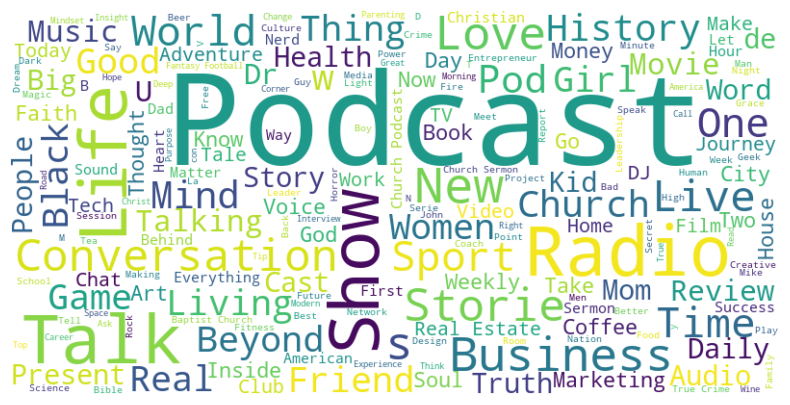

<IPython.core.display.Javascript object>

In [8]:
# If image not show, try uncommenting the following line:
# %matplotlib inline

# Connect to the SQLite database
conn = sqlite3.connect(database)

# Query to get all titles from the podcasts table
query = "SELECT title FROM podcasts"

# Execute the query and load the data into a DataFrame
titles_df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Create a single string with all titles
title_corpus = " ".join(titles_df["title"].tolist())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    title_corpus
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

Popular words in titles of podcasts seems to be:
- Podcast;
- Talk;
- Radio;
- Show;
- Life.

Which are a kind of generic words for such content.

## Rating scores

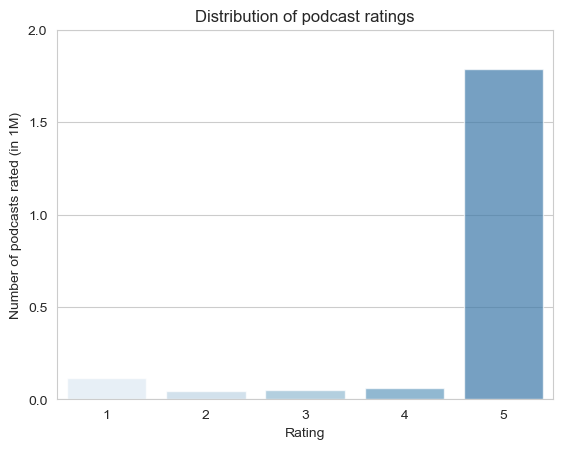

<IPython.core.display.Javascript object>

In [15]:
# Connect to the SQLite database
conn = sqlite3.connect(database)

# Query to count number of each rating and execute as well as load the data
SQL_query = """
SELECT rating, COUNT(*) as count 
FROM reviews 
GROUP BY rating
"""

rating_counts = pd.read_sql_query(SQL_query, conn)

# Close SQL connection
conn.close()

# Plot
ax = sns.barplot(x="rating", y="count", data=rating_counts, alpha=0.7)
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x/1e6:,.1f}")
plt.yticks([0, 5e5, 1e6, 1.5e6, 2e6])
plt.title("Distribution of podcast ratings")
plt.ylabel("Number of podcasts rated (in 1M)")
plt.xlabel("Rating")

plt.show()

Major fraction of the podcasts is received perfectly. Although an important thing to note here is that users rate podcast when they have very positive or very negative opinion, as '1' and '5' rating is most common.

In [10]:
# Connect to SQLite and execute query
conn = sqlite3.connect(database)
df_reviews_per_usr = pd.read_sql_query(
    "SELECT DISTINCT author_id, podcast_id FROM reviews", conn
)

# Close SQL connection
conn.close()

# Calculate the average number of distinct podcasts reviewed per user
podcast_counts = df_reviews_per_usr.groupby("author_id").size()
avg_podcasts = round(podcast_counts.mean(), 1)

print(f"Average number of podcasts reviewed per unique user: {avg_podcasts}")

Average number of podcasts reviewed per unique user: 1.3


<IPython.core.display.Javascript object>

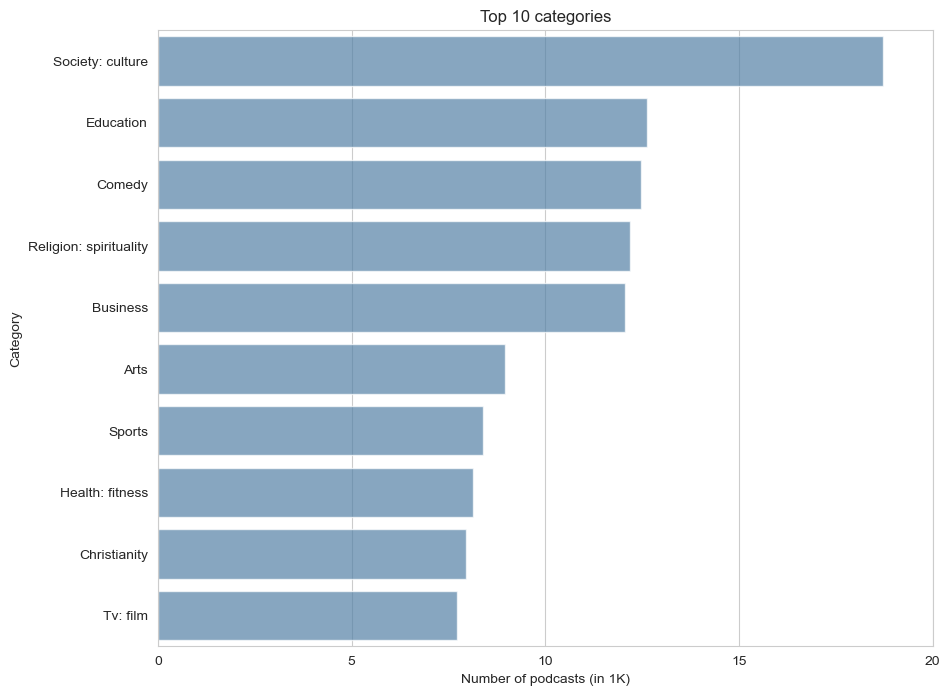

<IPython.core.display.Javascript object>

In [17]:
# Connect to the SQLite database
conn = sqlite3.connect(database)

# Query to count number of podcasts in each category and order descending, execute
SQL_query = """
SELECT category, COUNT(*) as count 
FROM categories 
GROUP BY category
ORDER BY count DESC
"""

category_counts = pd.read_sql_query(SQL_query, conn)

# Close SQL connection
conn.close()

# Filter Top 10 categories
top_categories = category_counts.head(10)

# Rename (only for clarity in the graphs, renaming of all entries is not necessary for further analysis)
top_categories.loc[:, "category"] = top_categories["category"].apply(
    lambda x: x.capitalize().replace("-", ": ")
)

# Renaming gives warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from
# a DataFrame. Try using .loc[row_indexer,col_indexer] = value instead". Warning is silenced, mind for
# the future.

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    y="category",
    x="count",
    data=top_categories,
    orient="h",
    color="steelblue",
    alpha=0.7,
)

plt.gca().xaxis.set_major_formatter(lambda x, _: f"{x/1e3:,.0f}")
plt.title("Top 10 categories")
plt.xlabel("Number of podcasts (in 1K)")
plt.xticks([0, 5e3, 1e4, 1.5e4, 2e4])
plt.ylabel("Category")

plt.show()

Among the most popular categories to make podcasts on one stand above all. It is *society*, more specifically *culture*. Other popular themes also include: *education, comedy, spirituality, and business*.

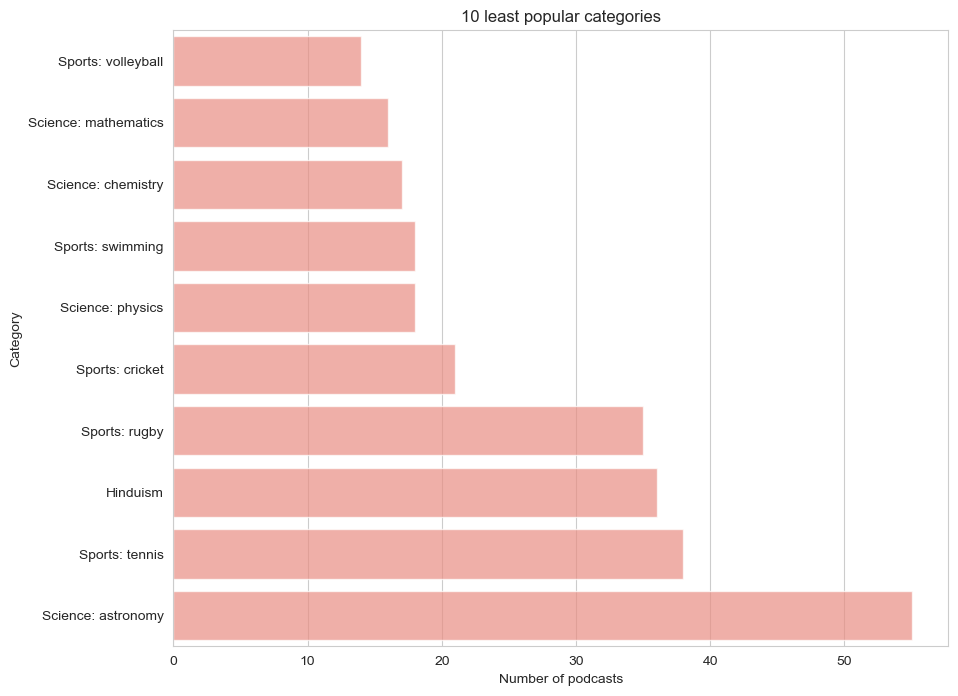

<IPython.core.display.Javascript object>

In [18]:
# Connect to the SQLite database
conn = sqlite3.connect(database)

# Query to count the number of podcasts in each category and order descending, execute SQL command
SQL_query = """
SELECT category, COUNT(*) as count 
FROM categories 
GROUP BY category
ORDER BY count DESC
"""

category_counts = pd.read_sql_query(SQL_query, conn)

# Close SQL connection
conn.close()

# Keep only bottom 10 categories
top_categories = category_counts.tail(10)
sorted_top_categories = top_categories.sort_values(by="count", ascending=True)

# Rename ("-")
sorted_top_categories.loc[:, "category"] = top_categories["category"].apply(
    lambda x: x.capitalize().replace("-", ": ")
)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    y="category",
    x="count",
    data=sorted_top_categories,
    orient="h",
    color="salmon",
    alpha=0.7,
)
plt.title("10 least popular categories")
plt.xlabel("Number of podcasts")
plt.ylabel("Category")

plt.show()

Very few podcasts are on specific types of sports, such as *volleyball* and *swimming*, as well as specific science topics, such as: *math, chemistry* and *physics*.

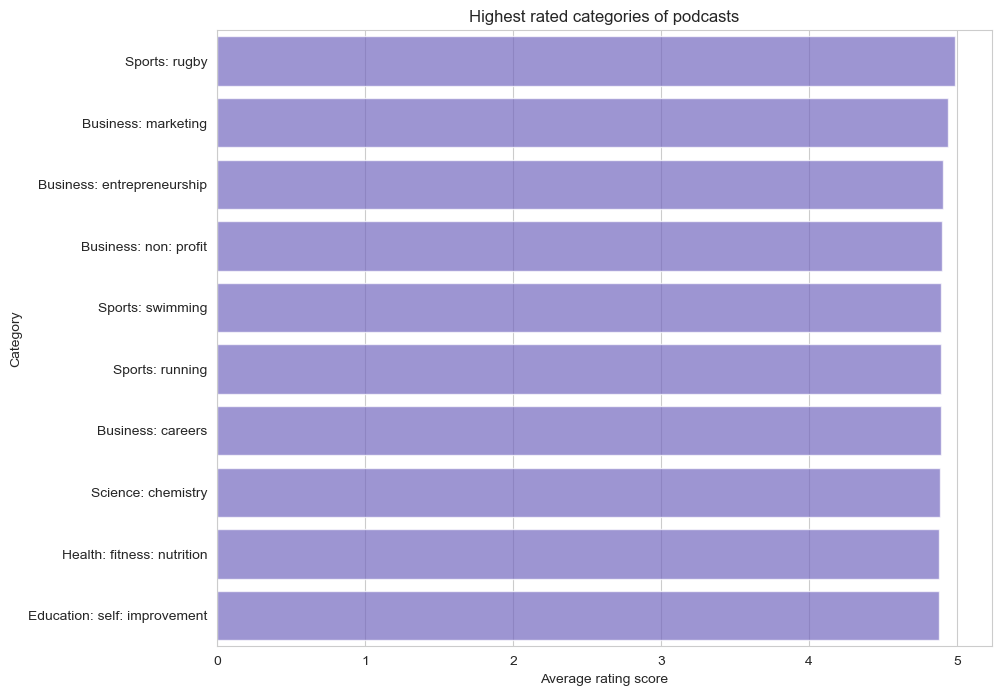

<IPython.core.display.Javascript object>

In [13]:
# Connect to SQLite database
conn = sqlite3.connect(database)

# Query
query = """
SELECT categories.category, AVG(reviews.rating) as avg_rating
FROM reviews
JOIN categories
ON reviews.podcast_id = categories.podcast_id
GROUP BY categories.category
"""

df_categories = pd.read_sql_query(query, conn)
conn.close()

# Sort by "avg_rating" select only 10 categories on top
top_rated_categories = df_categories.sort_values("avg_rating", ascending=False).head(10)

# Rename categories (only for clarity in the graphs, renaming of all entries is not necessary for further analysis)
top_rated_categories.loc[:, "category"] = top_rated_categories["category"].apply(
    lambda x: x.capitalize().replace("-", ": ")
)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    y="category",
    x="avg_rating",
    data=top_rated_categories,
    orient="h",
    color="slateblue",
    alpha=0.7,
)
plt.title("Highest rated categories of podcasts")
plt.xlabel("Average rating score")
plt.ylabel("Category")

plt.show()

Highest rated podcasts discuss sports and business.

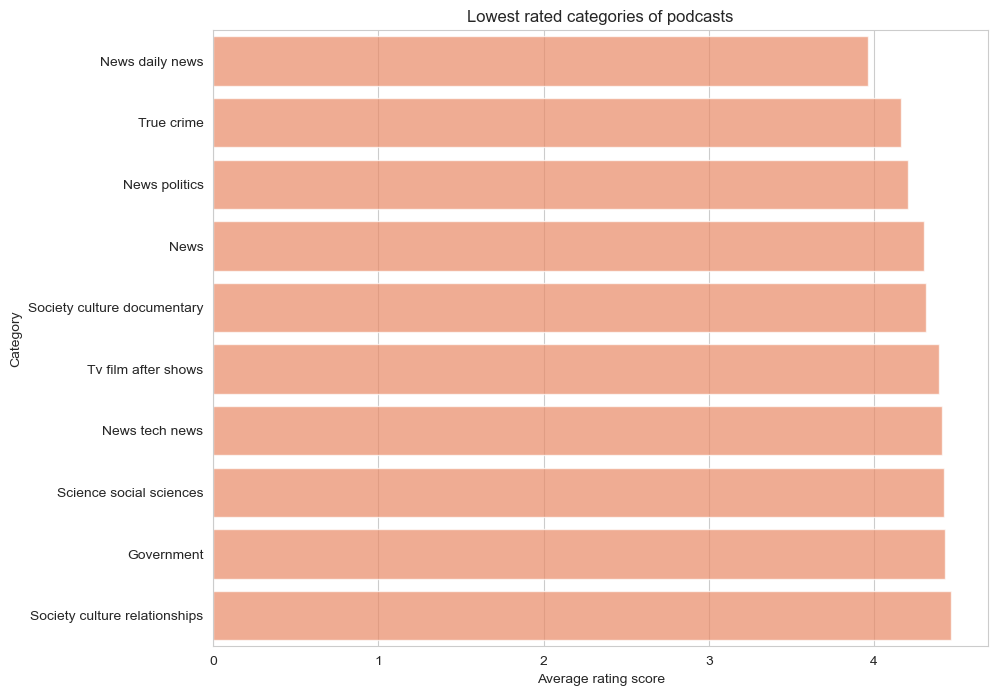

<IPython.core.display.Javascript object>

In [20]:
# Connect to SQLite database
conn = sqlite3.connect(database)

# Query
query = """
SELECT categories.category, AVG(reviews.rating) as avg_rating
FROM reviews
JOIN categories
ON reviews.podcast_id = categories.podcast_id
GROUP BY categories.category
"""

df_categories = pd.read_sql_query(query, conn)
conn.close()

# Sort by "average rating select only 10 categories on top, but noew descending sorting is in effect
worst_rated_categories = df_categories.sort_values("avg_rating", ascending=True).head(
    10
)

# Rename categories (only for clarity in the graphs, renaming of all entries is not necessary for further analysis)
worst_rated_categories.loc[:, "category"] = worst_rated_categories["category"].apply(
    lambda x: x.capitalize().replace("-", " ")
)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    y="category",
    x="avg_rating",
    data=worst_rated_categories,
    orient="h",
    color="coral",
    alpha=0.7,
)
plt.title("Lowest rated categories of podcasts")
plt.xlabel("Average rating score")
plt.ylabel("Category")

plt.show()

Lowest rated podcasts discuss various types of news.

Let's formulate null hypothesis as *H0*: **The rating given is not correlated on the podcast category.**
Then alternative hypothesis would be *H1*: **The rating given is correlated to the podcast category.**. Let's set value as p = 0.05 to conclude whether the correlation observation is statistically significant (such case would happen 95 % of the time).

In [22]:
# Connect to SQL, query, and load
conn = sqlite3.connect(database)
query = "SELECT category, rating FROM categories INNER JOIN reviews ON categories.podcast_id=reviews.podcast_id"
df = pd.read_sql_query(query, conn)

# Close SQL connection
conn.close()

# Chi-Square test
table = pd.crosstab(df["category"], df["rating"])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square statistic value: ", chi2)
print("p-value : ", p)
print("\n")

# Give immeadiate answer about the null hypothesis
if p <= 0.05:
    print(
        "Reject the null hypothesis! The rating given is correlated to the podcast category."
    )
else:
    print(
        "Null hypothesis is true! The rating given is not correlated on the podcast category."
    )

Chi-square statistic value:  177671.94712671387
p-value :  0.0


Reject the null hypothesis! The rating given is correlated to the podcast category.


<IPython.core.display.Javascript object>

## Review times

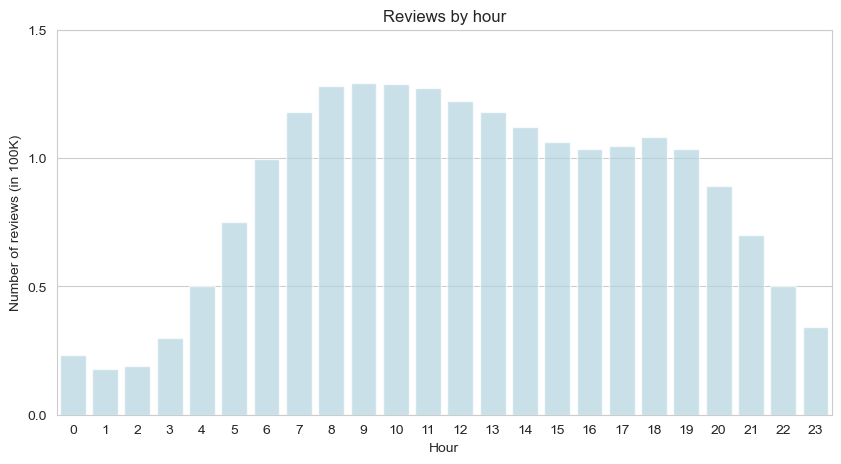

<IPython.core.display.Javascript object>

In [23]:
# Connect to the SQLite database
conn = sqlite3.connect(database)

# Query to extract time info from "reviews" table, execute and create df
SQL_query = "SELECT created_at FROM reviews"
review_time_df = pd.read_sql_query(SQL_query, conn)

# Close SQL connection
conn.close()

# Create datetime
review_time_df["created_at"] = pd.to_datetime(review_time_df["created_at"])

# Get hour info
review_time_df["hour"] = review_time_df["created_at"].dt.hour

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(x="hour", data=review_time_df, color="lightblue", alpha=0.7)
plt.title("Reviews by hour")
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x/1e5:,.1f}")
plt.yticks([0, 5e4, 1e5, 1.5e5])
plt.xlabel("Hour")
plt.ylabel("Number of reviews (in 100K)")

plt.show()

Reviews are consistently written in the first half of the day. I would suspect people listen to podcast while commuting and then leave the feedback.

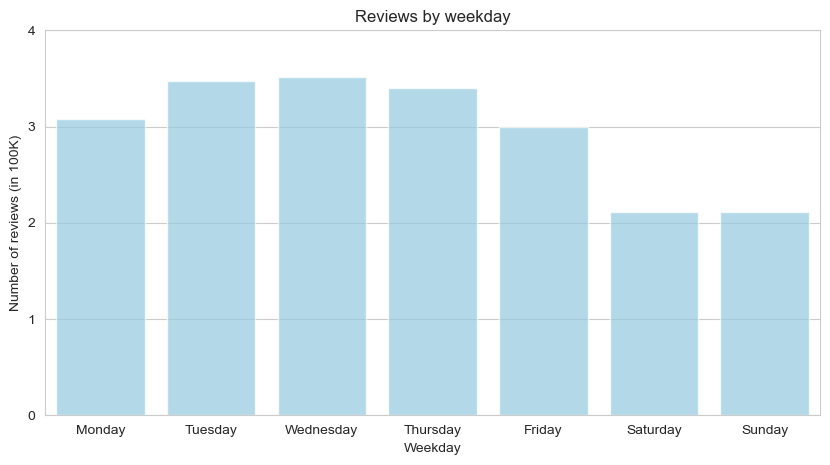

<IPython.core.display.Javascript object>

In [24]:
# Get day of week
review_time_df["day_of_week"] = review_time_df["created_at"].dt.dayofweek

# Map day of week counts to names of weekdays
review_time_df["day_of_week"] = review_time_df["day_of_week"].apply(
    lambda x: calendar.day_name[x]
)

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(
    x="day_of_week",
    data=review_time_df,
    color="skyblue",
    alpha=0.7,
    order=list(calendar.day_name),
)
plt.title("Reviews by weekday")
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x/1e5:,.0f}")
plt.yticks([0, 1e5, 2e5, 3e5, 4e5])
plt.xlabel("Weekday")
plt.ylabel("Number of reviews (in 100K)")

plt.show()

Middle of the week (Wednesday) is the most common day to leave feedback. This further solidifies my idea that people listen to podcasts while commuting and have little time to do that on weekends.

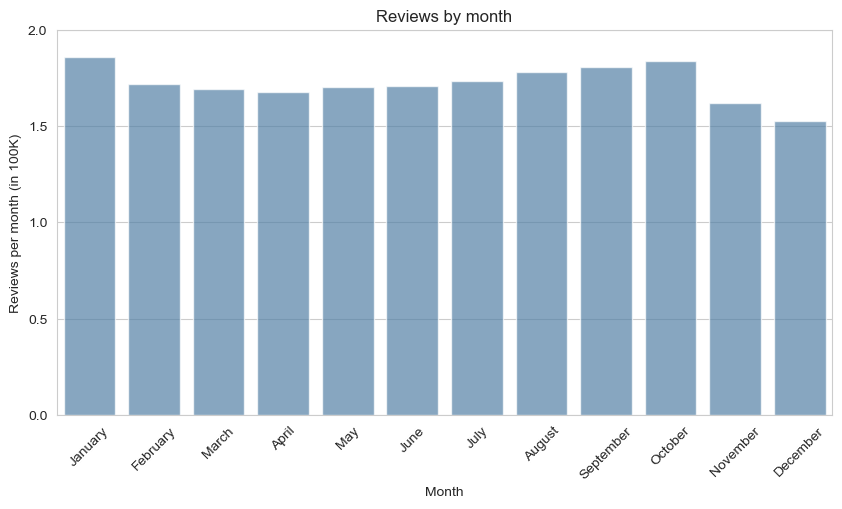

<IPython.core.display.Javascript object>

In [25]:
# Get month from "created_at"
review_time_df["month"] = review_time_df["created_at"].dt.month

# Map month counts to names
review_time_df["month"] = review_time_df["month"].apply(
    lambda x: calendar.month_name[x]
)

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(
    x="month",
    data=review_time_df,
    color="steelblue",
    alpha=0.7,
    order=list(calendar.month_name[1:]),
)
plt.title("Reviews by month")
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x/1e5:,.1f}")
plt.yticks([0, 5e4, 1e5, 1.5e5, 2e5])
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Reviews per month (in 100K)")

plt.show()

Most common month to leave feedback is January, while least common - just before it, thus January. I suspect people get busy preparing for end-of-year celebrations and leave no time for listening, although why one wouldn't listen while standing in line, when shopping for presents? There may be some spare time in January as there is not much to do, and it is cold and dark outside, which increases the listening. Although, I should be cautious to draw such conclusions as the times correspond to writing a review, not necessarily to listening to it. But... who writes a review month after the interaction? Maybe someone.

In [26]:
# Get year info from all review times
review_time_df["year"] = review_time_df["created_at"].dt.year

# Only leave uniwue years
unique_years = sorted(review_time_df["year"].unique())

print("Dataset contains reviews from following years:")
print(unique_years)

Dataset contains reviews from following years:
[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


<IPython.core.display.Javascript object>

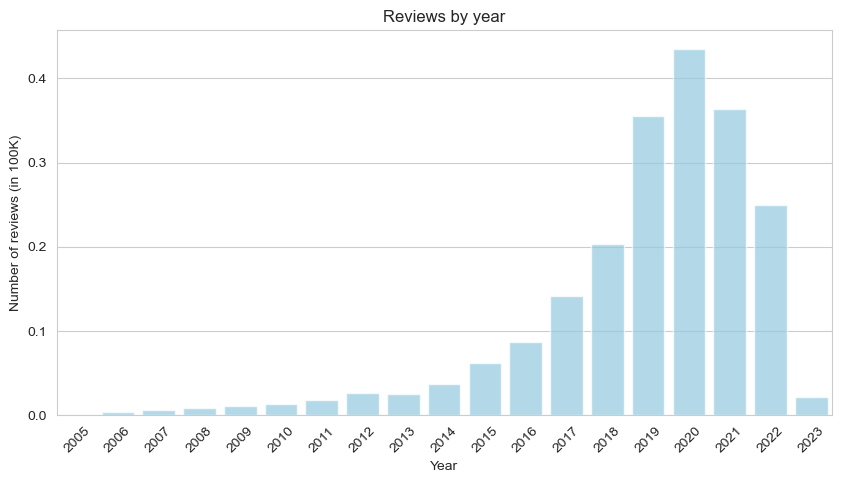

<IPython.core.display.Javascript object>

In [27]:
# Get year info from all review times
review_time_df["year"] = review_time_df["created_at"].dt.year

# Count the number of reviews each year
reviews_per_year = review_time_df.groupby("year").size()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    x=reviews_per_year.index, y=reviews_per_year.values, color="skyblue", alpha=0.7
)
plt.title("Reviews by year")
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x/1e6:,.1f}")
plt.yticks([0, 1e5, 2e5, 3e5, 4e5])
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Number of reviews (in 100K)")

plt.show()

My initial assumption was that pandemic year (2020) will be the busiest considering podcasts, as people had not much else to do. And it is correct. Although it is surprising that popularity of podcasts were steadily rising even in pre-COVID era thus it is hard to tell if pandemy had much to do with the popularity. Maybe the oposite, as podcast review enteries started to decline in the following yeras?

More analysis on review times can be found in Google Looker Studio (link in *Project description*). 

## Comment analysis

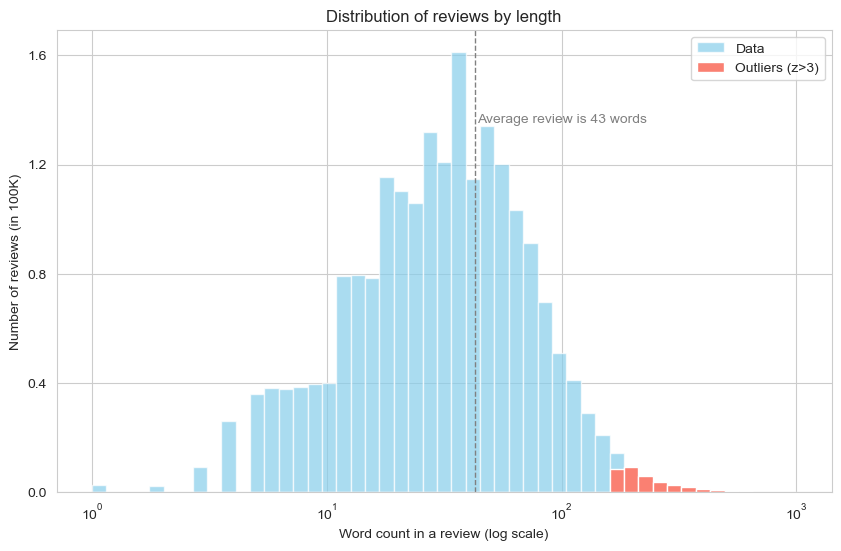

<IPython.core.display.Javascript object>

In [28]:
# Connect to the SQLite database
conn = sqlite3.connect(database)

# Query to SQL and load results
SQL_query = "SELECT content FROM reviews"

review_text_df = pd.read_sql_query(SQL_query, conn)

# Close connection
conn.close()

# Calculate number of words in each review text
review_text_df["word_count"] = review_text_df["content"].str.split().str.len()

# Calculate Z-scores and select z value for "above" values, look for outliers,
# set threshold to 3 (thus 3 std from mean)
review_text_df["zscore"] = zscore(review_text_df["word_count"])
threshold = 3
outliers = review_text_df[review_text_df["zscore"].abs() > threshold]

# Calculate mean
mean_word_count = review_text_df["word_count"].mean()

# Plot (normal data)
plt.figure(figsize=(10, 6))
plt.hist(
    review_text_df["word_count"],
    bins=np.logspace(np.log10(1), np.log10(1e3), 50),
    alpha=0.7,
    label="Data",
    color="skyblue",
)
# Plot (outliers)
plt.hist(
    outliers["word_count"],
    bins=np.logspace(np.log10(1), np.log10(1e3), 50),
    label="Outliers (z>3)",
    color="salmon",
)

# Display mean value
plt.axvline(mean_word_count, color="grey", linestyle="dashed", linewidth=1)
plt.text(
    mean_word_count + 1,
    plt.gca().get_ylim()[1] * 0.8,
    f"Average review is {mean_word_count:.0f} words",
    color="grey",
)

# Graph configuration
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x/1e5:,.1f}")
plt.yticks([0, 4e4, 8e4, 1.2e5, 1.6e5])
plt.gca().set_xscale("log")
plt.legend()
plt.title("Distribution of reviews by length")
plt.xlabel("Word count in a review (log scale)")
plt.ylabel("Number of reviews (in 100K)")

plt.show()

In [34]:
# Function to calculate review sentiment score
def get_review_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity


# Connect to the SQLite database
conn = sqlite3.connect(database)

# Fetch reviews, user_ids and lengths (author_id is not used in this analysis,
# but may be used to enhance this analysis)
df_review_sent = pd.read_sql_query("SELECT author_id, content FROM reviews", conn)

df_review_lengths = pd.read_sql_query(
    "SELECT LENGTH(content) as review_length FROM reviews", conn
)

# Close the connection
conn.close()

# Calculate sentiment score (represented as polarity) for each review and join with lengths
df_review_sent["sentiment_polarity"] = df_review_sent["content"].apply(
    get_review_sentiment
)
df_of_sentiments = df_review_sent.join(df_review_lengths)

<IPython.core.display.Javascript object>

In [35]:
# Display example of what was calculated
df_of_sentiments.head()

,author_id,content,sentiment_polarity,review_length
0,F7E5A318989779D,Thanks for providing these insights. Really e...,0.350000,100
1,F6BF5472689BD12,Super excited to see this podcast grow. So man...,0.328423,178
2,1AB95B8E6E1309E,"I'm a liberal myself, but its pretty obvious a...",-0.008333,233
3,11BB760AA5DEBD1,I find Tedx talks very inspirational but I oft...,0.527778,158
4,D86032C8E57D15A,"I love this podcast, it is so good.",0.600000,35


<IPython.core.display.Javascript object>

In [32]:
# Sort df_of_sentiments by sentiment polarity
df_sentiments_sorted = df_of_sentiments.sort_values(by="sentiment_polarity")

# print most NEGATIVE review
most_negative_review = df_sentiments_sorted.iloc[0]["content"]
print(f":( Most negative podcast review: \n{most_negative_review}\n")

# print most NEUTRAL review
most_neutral_review = df_sentiments_sorted.iloc[
    (df_sentiments_sorted["sentiment_polarity"] - 0).abs().argsort()[:1]
]
most_neutral_review = most_neutral_review["content"].values[0]
print(f":| Most neutral podcast review: \n{most_neutral_review}\n")

# print most POSITIVE review
most_positive_review = df_sentiments_sorted.iloc[-1]["content"]
print(f":) Most positive podcast review: \n{most_positive_review}\n")

:( Most negative podcast review: 
Ricky...love your content, but the audio is terrible in almost all of the episodes. 😥

:| Most neutral podcast review: 
I can’t even stand the ads for this show.

:) Most positive podcast review: 
An encouraging and uplifting podcast with great people!  Jordyn’s story is awesome!  Share with your family and friends to make their day!  Thank you for educating and encouraging us all ❤️



<IPython.core.display.Javascript object>

Let's formulate null hypothesis as *H0*: **Length of a review is uncorrelated with the negative opinion of the review.** Then alternative hypothesis would be *H1*: **Longer reviews are associated with more negativity in the review.** Let's set value as p = 0.05 to conclude whether the correlation observation is statistically significant (such case would happen 95 % of the time).

In [33]:
# Compute Pearson correlation coefficient (PCC)
corr, p_value = pearsonr(
    df_of_sentiments["review_length"], df_of_sentiments["sentiment_polarity"]
)

print("Pearson Correlation Coefficient: ", corr)
print("p-value: ", p_value)
print("\n")

# Give immeadiate answer about the null hypothesis
if p_value <= 0.05:
    print(
        "Reject the null hypothesis! Longer reviews are associated with more negativity in the review."
    )
else:
    print(
        "Null hypothesis is true! Length of a review is uncorrelated with the negative opinion of the review."
    )

Pearson Correlation Coefficient:  -0.17041689530760695
p-value:  0.0


Reject the null hypothesis! Longer reviews are associated with more negativity in the review.


<IPython.core.display.Javascript object>

# Concluding remarks

Podcast names usually include words such as *podcast, talk, radio,* and *show*. Podcasts tend to be well received, in general. There are a lot of podcasts on culture, but little on specialized sports and science categories. Hosts of podcasts on news should try to improve those, as they are among worst rated. Or maybe frequent negativity in news just biases reviewers to receive those podcasts not so well. People tend to write reviews in the first part of the day, in the middle of work week, and in January. Average review length is 43 words.

Important statistical observations:
- Longer reviews are associated with more negativity in the review.
- The rating given is correlated to the podcast category.

Future suggestion: it would be interesting to see if people who write negative reviews tend to write negative reviews and vice versa. However, as average reviewer only gave 1.3 reviews on average, such analysis would be unconvincing. More/different data would be useful.